In [39]:
import collections
import pathlib
import pickle
from typing import Dict, Tuple, Sequence
import cv2
from skimage.color import rgb2lab, lab2rgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


폴더 경로 설정

In [ ]:
# 코랩진행시 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

In [40]:
#코랩진행시 아래 폴더 경로 코랩폴더로 변경 필요
csvfile = "./datasets/dataset.csv"
srcimgfolder="./datasets/refined_img/"
inputfolder="./datasets/data/input/"
outputfolder="./datasets/data/output/"
oldpalette="./datasets/data/old_palette/"
newpalette="./datasets/data/new_palette/"


csv파일에서 이미지 이름과 색상정보 불러온 후 세트 만들기

In [41]:
####create palette set from csv file.
import csv

image_to_palette = collections.defaultdict(set)

with open(csvfile, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  

    for row in reader:
        #print(row)
        #print(row[2])
        media_filename=row[1]
        color_palette=row[2].replace('[', '{').replace(']', '}').replace("'", "").replace(" ", "")

        #rgbcode=row[3]
        image_to_palette[media_filename] = set(color_palette[1:-1].split(','))

In [42]:
print(media_filename)
print(image_to_palette)

img_4301.jpg
defaultdict(<class 'set'>, {'img_4299.jpg': {'#46373d', '#070707', '#f5d5b1', '#9d524b', '#f38d56', '#fdc87f'}, 'img_4300.jpg': {'#67604e', '#92d4fc', '#6ab6fb', '#312d23', '#9d8a6d', '#5483b7'}, 'img_4301.jpg': {'#c0c2c5', '#eaebeb', '#989da4', '#393a40', '#62411c', '#646f7e'}})


이미지 및 생성된 파레트 확인용

In [43]:
def viz_color_palette(hexcodes):

    hexcodes = list(hexcodes)
    while len(hexcodes) < 6: 
        hexcodes = hexcodes + hexcodes
    hexcodes = hexcodes[:6] 

    palette = []
    for hexcode in hexcodes:
        rgb = np.array(list(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
        palette.append(rgb)

    palette = np.array(palette)[np.newaxis, :, :]
    return palette


def viz_image(path, image_to_palette: Dict):

    assert pathlib.Path(path).name in image_to_palette
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    palette = viz_color_palette(image_to_palette[pathlib.Path(path).name])

    # visualize image
    plt.imshow(img)
    plt.show()

    # visualize color palette
    print(palette.shape)
    plt.imshow(palette)
    # print(palette.shape)
    plt.axis('off')
    plt.show()

    return

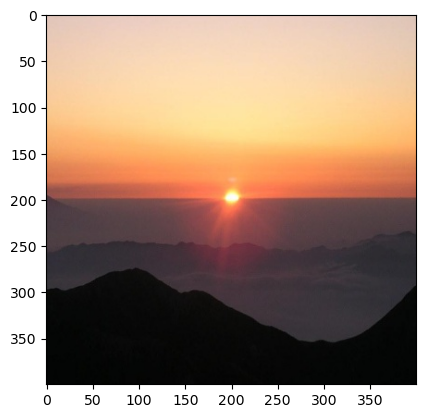

(1, 6, 3)


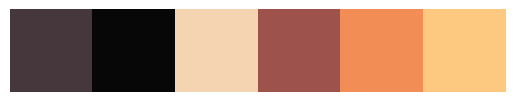

In [44]:
#check image and paletteset

import glob

pathlist = pathlib.Path(srcimgfolder).glob("*.jpg")
for path in pathlist:
    #print(path)
    viz_image(path, image_to_palette)
    break

색상증강 진행

In [45]:
# generate augmented images for training
#    - input/: images with original palette
#    - output/: images with new palette
#    - old_palette/: pickled files of original palette
#    - new_palette/: pickled files of new palette

def augment_image(img, title, hue_shift):
    # RGB -> HSV -> hue-shift
    img_HSV = matplotlib.colors.rgb_to_hsv(img)
    a_2d_index = np.array([[1,0,0] for _ in range(img_HSV.shape[1])]).astype('bool')
    img_HSV[:, a_2d_index] = (img_HSV[:, a_2d_index] + hue_shift) % 1
    new_img = matplotlib.colors.hsv_to_rgb(img_HSV).astype(int)

    # fixed original luminance
    img = img.astype(float) / 255.0
    new_img = new_img.astype(float) / 255.0
    ori_img_LAB = rgb2lab(img)
    new_img_LAB = rgb2lab(new_img)
    new_img_LAB[:, :, 0] = ori_img_LAB[:, :, 0]
    new_img_augmented = (lab2rgb(new_img_LAB)*255.0).astype(int)

    return new_img_augmented


pathlist = pathlib.Path(srcimgfolder).glob("*.jpg") #srcimgfolder
for i, path in enumerate(sorted(pathlist)):
    print(i,path.name,path)
   
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    palette = viz_color_palette(image_to_palette[pathlib.Path(path).name])



    for i in range (20,360,40): #20,60,100,140,180,220,260,300,340 9*

      hue_shift = i/360
      augmented_image = augment_image(img, "Image", hue_shift)
      augmented_palette = augment_image(palette, "Palette", hue_shift)

      cv2.imwrite(inputfolder+path.name[:-4]+str(i)+path.name[-4:], img) 
      pickle.dump(palette, open(oldpalette+path.stem+str(i)+'.pkl', 'wb'))
      cv2.imwrite(outputfolder+path.name[:-4]+str(i)+path.name[-4:], augmented_image)
      pickle.dump(augmented_palette, open(newpalette+path.stem+str(i)+'.pkl', 'wb'))

0 img_4299.jpg datasets\refined_img\img_4299.jpg
1 img_4300.jpg datasets\refined_img\img_4300.jpg
2 img_4301.jpg datasets\refined_img\img_4301.jpg


랜덤 색상파레트 확인

In [46]:
oldpal="./datasets/data/old_palette/img_4299100.pkl"
newpal="./datasets/data/new_palette/img_4299100.pkl"
old_palette = pickle.load(open(oldpal, 'rb'))
new_palette = pickle.load(open(newpal, 'rb'))

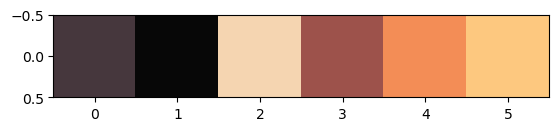

In [47]:
plt.imshow(old_palette)

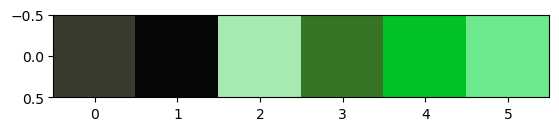

In [48]:
plt.imshow(new_palette)

코랩용 이미지확인

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
print("-----src----")
cv2_imshow(cv2.imread(srcimg))
print("-------------")
print("-----input/imread, normal----")
cv2_imshow(cv2.imread(inputimg, cv2.IMREAD_COLOR))
cv2_imshow(cv2.imread(inputimg))
print("-------------")
print("-----output----")
cv2_imshow(cv2.imread(outputimg))
